# Pairs-Trading in the Automotive Industry
This notebook aims to research possible highly correlated and cointegrated assets in the Consumer Discretionary sector, particularly the automotive industry. They will then be used in pairs trading to take advantage of statistical arbitrage in a mean-reversion strategy. Thereafter, backtests will be conducted to see their performance.

## Preparations

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import coint

## 1. Universe and Stock Selection
### 1.1 Retrieving data
From the Consumer Discretionary sector, we filter out a list of automotive stocks, both traded in NYSE and NASDAQ. We then attain their tickers and store it in a list.

In [2]:
NYSE = pd.read_excel('NYSE_Auto.xls')
NASDAQ = pd.read_excel('NASDAQ_Auto.xls')

# Remove nan value
NYSE = NYSE[:-1]
NASDAQ = NASDAQ[:-1]

In [3]:
NYSE

,S.No.,Company Name,Ticker,Country
0,1.0,Ferrari N.V.,RACE,Italy
1,2.0,Fisker Inc.,FSR,USA
2,3.0,Ford Motor Company,F,USA
3,4.0,General Motors Company,GM,USA
4,5.0,Honda Motor Company Ltd.,HMC,Japan
5,6.0,Oshkosh Corporation,OSK,USA
6,7.0,Stellantis N.V.,STLA,United Kingdom
7,8.0,Tata Motors Ltd,TTM,India
8,9.0,Toyota Motor Corporation,TM,Japan
9,10.0,XPeng Inc.,XPEV,China


In [4]:
NASDAQ

,S.No.,Company,Ticker,Country
0,1.0,Electrameccanica Vehicles Corp. Ltd.,SOLO,Canada
1,2.0,Ideanomics Inc.,IDEX,USA
2,3.0,Kandi Technologies Group Inc,KNDI,China
3,4.0,Li Auto Inc.,LI,China
4,5.0,Lordstown Motors Corp.,RIDE,USA
5,6.0,Nikola Corporation,NKLA,USA
6,7.0,Niu Technologies,NIU,China
7,8.0,PACCAR Inc.,PCAR,USA
8,9.0,Tesla Inc.,TSLA,USA
9,10.0,The Shyft Group Inc.,SHYF,USA


In [5]:
# Converting tickers to a list
tickers = NASDAQ['Ticker'].tolist() + NYSE['Ticker'].tolist()
tickers

['SOLO',
 'IDEX',
 'KNDI',
 'LI',
 'RIDE',
 'NKLA',
 'NIU',
 'PCAR',
 'TSLA',
 'SHYF',
 'WKHS',
 'RACE',
 'FSR',
 'F',
 'GM',
 'HMC',
 'OSK',
 'STLA',
 'TTM',
 'TM',
 'XPEV']

Here, we get the historical data for automobiles in the past 10 years.

In [6]:
# Training set
start = '2012-01-01'
end = '2022-04-01'
prices = yf.download(tickers, start=start, end=end)['Adj Close']

[*********************100%%**********************]  21 of 21 completed


2 Failed downloads:
['TTM', 'RIDE']: Exception('%ticker%: No timezone found, symbol may be delisted')


### 1.2 Cleaning up data, training and test sets
As there are a couple tickers with significantly insuffcient historical data, we remove them from our universe. They present insufficient data, which might result in data-snooping bias during backtesting, hence their removal.

In [7]:
prices = prices.dropna(axis=1)
prices

,F,GM,HMC,IDEX,KNDI,OSK,PCAR,SHYF,STLA,TM,TSLA,WKHS
Date,,,,,,,,,,,,
2012-01-03,6.579117,16.070389,24.962540,562.50,3.51,19.277365,17.178225,4.350481,1.844821,59.586098,1.872000,4.90
2012-01-04,6.679607,16.146729,25.169636,562.50,3.18,19.698681,17.111816,4.290059,1.963446,60.157520,1.847333,4.30
2012-01-05,6.851028,16.925432,25.392653,562.50,3.12,19.733078,17.868895,4.393641,1.963446,60.324562,1.808000,3.10
2012-01-06,6.921962,17.498014,25.591785,562.50,3.19,19.870646,17.771486,4.367745,1.963446,60.227859,1.794000,4.50
2012-01-09,6.975162,17.436937,25.528065,562.50,3.36,20.472519,17.984009,4.246899,1.979808,60.148743,1.816667,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,14.508594,43.116013,27.656065,115.00,2.94,104.220757,56.309643,37.555252,13.458344,178.429993,336.880005,4.33
2022-03-28,14.684776,43.679035,27.422680,118.75,3.03,102.776733,56.518509,38.272739,13.509259,177.850006,363.946655,4.43
2022-03-29,15.636158,45.694077,28.655712,130.00,3.32,105.451553,57.562801,39.540630,14.493602,184.809998,366.523346,4.96


We then split the dataset into training and test sets, whereby we make use of 5 years of historical data for training

In [8]:
train = np.arange(0, 1260) # trading days in 5 years
test = np.arange(train.shape[0], prices.shape[0])

### 1.3 Finding Potential Pairs
We find the spearman correlation coefficient here in our universe to determine which stocks are highly correlated to one another, as visualised via a heatmap. The coefficients are calculated using the training set (first 5 years of historical data). Afterwards, we selectively pick out pairs that have a correlaton coefficient >= 0.7 in order to more efficiently filter out possible pairs.

The spearman correlation is chosen over the pearson correlation as we want to measure monotonicity between them.

In [9]:
# Correlation heatmap
def correlation_matrix(df, is_plot=False):
    
    # Get feature correlations and transform to dataframe
    correlated = df.corr(method='spearman')

    if is_plot:
        plt.figure(figsize=(10, 10))
        plt.imshow(correlated, cmap='RdYlGn', interpolation='none', aspect='auto')
        plt.colorbar()
        plt.xticks(range(len(correlated)), correlated.columns, rotation='vertical')
        plt.yticks(range(len(correlated)), correlated.columns);
        plt.suptitle('Spearman Correlation Heat Map', fontsize=15, fontweight='bold')
        plt.show()

    return correlated

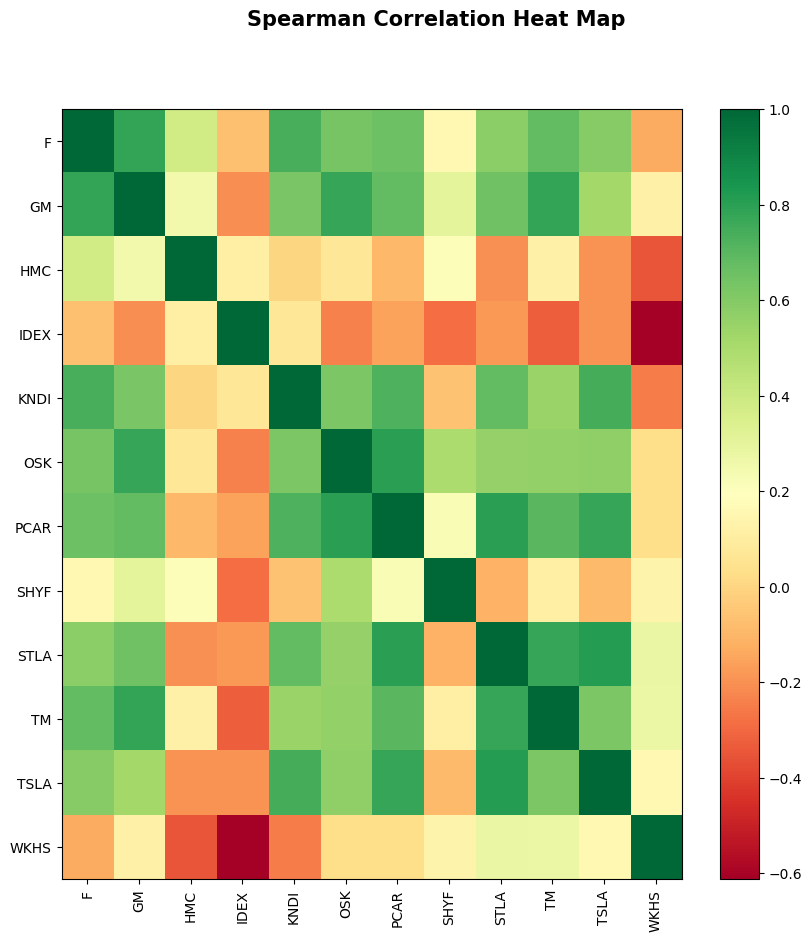

In [10]:
corr = correlation_matrix(prices.iloc[train], is_plot=True)

In [11]:
corr

,F,GM,HMC,IDEX,KNDI,OSK,PCAR,SHYF,STLA,TM,TSLA,WKHS
F,1.000000,0.784823,0.382128,-0.070757,0.737585,0.632295,0.653889,0.159055,0.579759,0.682593,0.590612,-0.129880
GM,0.784823,1.000000,0.248033,-0.208207,0.623883,0.775980,0.681193,0.301407,0.651268,0.782160,0.515234,0.122189
HMC,0.382128,0.248033,1.000000,0.111909,0.002442,0.068084,-0.092806,0.211262,-0.199746,0.120822,-0.193359,-0.348238
IDEX,-0.070757,-0.208207,0.111909,1.000000,0.072769,-0.237404,-0.157875,-0.289872,-0.180033,-0.327816,-0.192261,-0.612764
KNDI,0.737585,0.623883,0.002442,0.072769,1.000000,0.619876,0.726769,-0.063004,0.680902,0.545587,0.744282,-0.248066
OSK,0.632295,0.775980,0.068084,-0.237404,0.619876,1.000000,0.800140,0.494568,0.553300,0.560991,0.568321,0.034319
PCAR,0.653889,0.681193,-0.092806,-0.157875,0.726769,0.800140,1.000000,0.222161,0.799574,0.702295,0.774390,0.030455
SHYF,0.159055,0.301407,0.211262,-0.289872,-0.063004,0.494568,0.222161,1.000000,-0.109986,0.113242,-0.089235,0.136616
STLA,0.579759,0.651268,-0.199746,-0.180033,0.680902,0.553300,0.799574,-0.109986,1.000000,0.774553,0.813897,0.281690
TM,0.682593,0.782160,0.120822,-0.327816,0.545587,0.560991,0.702295,0.113242,0.774553,1.000000,0.620198,0.270137


In [12]:
# Unstack correlation matrix and get pairs with corr coefficient >= 0.8
corr_unstacked = corr.unstack()
sorted_corr = corr_unstacked.sort_values(kind='quicksort')

# Remove 1.0 corrcoeffs since they only exist between duplicate tickers
pairs = sorted_corr[np.logical_and(sorted_corr < 1.0, sorted_corr >= 0.7)]
pairs

TM    PCAR    0.702295
PCAR  TM      0.702295
      KNDI    0.726769
KNDI  PCAR    0.726769
F     KNDI    0.737585
KNDI  F       0.737585
TSLA  KNDI    0.744282
KNDI  TSLA    0.744282
TSLA  PCAR    0.774390
PCAR  TSLA    0.774390
STLA  TM      0.774553
TM    STLA    0.774553
GM    OSK     0.775980
OSK   GM      0.775980
GM    TM      0.782160
TM    GM      0.782160
GM    F       0.784823
F     GM      0.784823
PCAR  STLA    0.799574
STLA  PCAR    0.799574
PCAR  OSK     0.800140
OSK   PCAR    0.800140
TSLA  STLA    0.813897
STLA  TSLA    0.813897
dtype: float64

### 1.4 Testing for Cointegration (Engle-Granger)
Out of the highly-correlated pairs we have found, we attempt to find cointegrated pairs of stocks. As most historical price data is non-stationary, cointegration implies that their linear combination (market value) might be stationary, making it a suitable candidate for a mean-reversion strategy. 

The Engle-Granger test tests for cointegration, with the following hypothesis:
$$H_0: \text{ No cointegration exist }$$
$$H_A: \text{ Cointegration exist }$$

We test for this at the 5% singifiance level, iterating through the filtered pairs and return those with p-value $p < 0.05$.

In [13]:
# Engle-granger test
def engle_granger(asset1, asset2, prices, sig_level = 0.05):
    """
    asset1, asset2 [str]: name of tickers
    prices [pd.DataFrame]: df containing historical data
    sig_level [int]: significance level of which we are testing at
    """
    _, p, _ = coint(prices[asset1], prices[asset2])
    
    if p < sig_level:
        print(f'{asset1} and {asset2} are cointegrated')
        
pairs = pairs.index
pairs = pairs.tolist()
for asset1, asset2 in pairs:
    engle_granger(asset1, asset2, prices.iloc[train])

GM and OSK are cointegrated


#### 1.4 Exploring ther pair
Only `GM, OSK` and `GM, TM` are found to be cointegrated. To verify, we view plots of their time series.

**NOTE**: The function below was written to further assist with potential quantitative research of the same strategy. I'll leave this here for now.

In [14]:
def view_rs(cointegrated_pairs, prices):
    """
    Plots the cointegrate pairs
    cointegrated_pairs [arr(tuple)]: list of tuples containing cointegrated stock pairs
    prices [pd.DataFrame]: df containing historical data
    """
    n = len(cointegrated_pairs)
    fig, ax = plt.subplots(1, n, figsize=(21,6))

    for i in range(n):
        # Get name of pairs
        first = cointegrated_pairs[i][0]
        second = cointegrated_pairs[i][1]

        # Plot their time series
        prices[first].plot(c='r', ax=ax[i])
        prices[second].plot(c='b', ax=ax[i])
        
        ax[i].set_title(f'{first} and {second} Prices')
        ax[i].set_ylabel('Prices')
        ax[i].legend()
            
    plt.show()

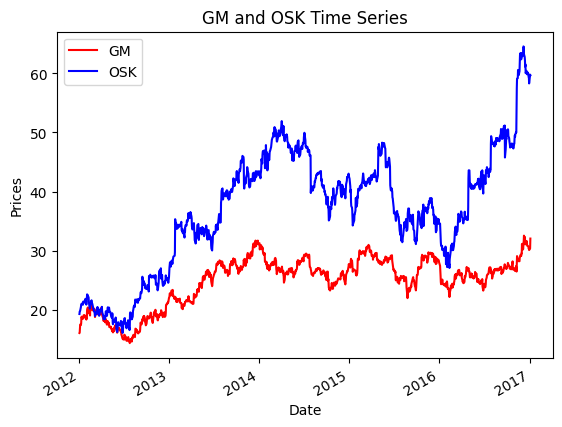

In [15]:
# View time-series of cointegrated pairs
prices.iloc[train]['GM'].plot(c='r')
prices.iloc[train]['OSK'].plot(c='b')
plt.legend()
plt.ylabel('Prices')
plt.title('GM and OSK Time Series')
plt.show()

## 2. Strategy
We create a spread between the selected pair, with one pair hedged the against another. Our exit and entry thresholds will then be determined by the z-score of the spread based on the training set.

#### 2.1 Determing Hedge Ratio
As the order of assets in the Engle-Granger test matters, we hence use GM as our target for both. To find the hedge ratio of the spread, we perform a regression of GM against TM. This will all be done on the training set.

In [16]:
model = sm.OLS(prices.iloc[train]['GM'], prices.iloc[train]['OSK']).fit() 

In [17]:
hedge = model.params[0]
hedge

0.6493590963963585

#### 2.2 Creating spread
We take the spread between the two pairs as our financial instrument

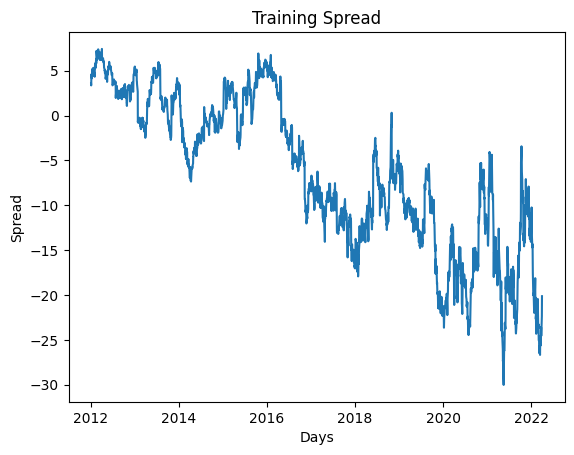

In [18]:
spread = prices['GM'] - hedge * prices['OSK']

# Plot spread for training set


plt.plot(spread)
plt.ylabel(f"Spread")
plt.xlabel("Days")
plt.title(f"Training Spread");

#### 2.3 Creating z-scores based on training data
The z-scores will be used to execute the follow strategy:
- Short spread when z >= 1
- Long spread when z <= -1
- Close short when z <= 0.5
- Close long when z >= -0.5

This strategy is employed to capture statistical arbitrage, taking advantage of the fact that the spread will return to equilibrium.

In [19]:
mu = np.mean(spread.iloc[train])
std = np.std(spread.iloc[train])
zscore = (spread - mu) / std

## 3. Backtesting
Backtesting of the strategy is done here on the entire dataset. Note that any testing done on the training set here would contain look-ahead bias. Ultimately, we will only assess the results of our strategy based on the out-of-sample portion of the backtest.

#### 3.1 Backtesting Using Exit and Entry Thresholds

In [20]:
# Adding positions to DataFrame

prices['LongGM'] = 0
prices['LongOSK'] = 0
prices['ShortGM'] = 0
prices['ShortOSK'] = 0
    
prices.loc[zscore >= 3, ('ShortGM', 'ShortOSK')] = [-1, 1]

# Long spread
prices.loc[zscore <= -3, ('LongGM', 'LongOSK')] = [1, -1]

# Exit short positions
prices.loc[zscore <= 1, ('ShortGM', 'ShortOSK')] = 0

# Exit long positions
# Long spread
prices.loc[zscore >= -1, ('LongGM', 'LongOSK')] = 0

# Ensure existing positions carried forward unless exit signal
prices.fillna(method='ffill', inplace=True)

In [21]:
# Finding positions for eachh day
long = prices.loc[:, ('LongGM', 'LongOSK')]
short = prices.loc[:, ('ShortGM', 'ShortOSK')]

positions = np.array(long) + np.array(short)
positions = pd.DataFrame(positions)

#### 3.2 Sharpe Ratio
We calculate the Sharpe Ratio of the strategy on the test set. We disregard the in-sample training Sharpe as that would result in look-ahead bias. As this strategy does not trade frequently, we can ignore the risk-free rate in our calculations of the Sharpe ratio.

In [22]:
# Returns from training set
returns = prices.loc[:, ('GM', 'OSK')].pct_change()

Text(0.5, 1.0, 'Out-of-sample PnL')

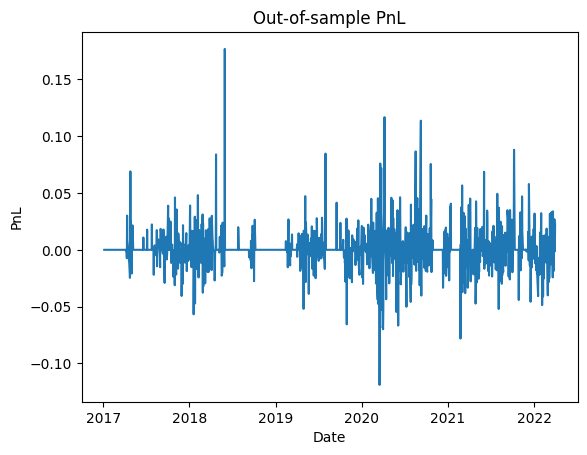

In [23]:
# Daily PnL based on our positions
pnl = np.array(positions.shift()) * np.array(returns)
pnl = pnl.sum(axis=1)

plt.plot(prices.iloc[test].index, pnl[test])
plt.ylabel('PnL')
plt.xlabel('Date')
plt.title('Out-of-sample PnL')

In [24]:
# Sharpe ratio for test set
testSharpe = np.sqrt(252) * np.mean(pnl[test]) / np.std(pnl[test])
print(f'Out-of-sample Sharpe is {testSharpe}')

Out-of-sample Sharpe is 0.6178137968734166


The test Sharpe shows that the strategy seems to be working decently outside of the training set. However, further improvements can be made to improve upon this.

## 4. Risk Management
Determination of the optimal leverage of the strategy in order to maximise long-term compounded growth can be done via the Kelly formula:
$$f_{i} = \frac{m_{i}}{s_{i}^{2}}$$

The Kelly formula should be updated constantly based on a lookback window in order to find the new optimal leverage. Furthermore, any change in equity should be taken into account before applying the leverage. Here, we find the optimum leverage that should be applied using the entire test set.

In [25]:
def kelly(dailyret):
    """
    Calculates mean excess returns, variance of returns, as well as the optimal leverage
    dailyret: pd.DataFrame containing daily returns
    """
    m = 252 * np.mean(dailyret)
    s = 252 * np.std(dailyret)**2
    f = m / s
    print(f'Mean Excess Returns: {m}')
    print(f'Variance of Excess Returns: {s}')
    print(f'Estimated optimal leverage: {f}')

kelly(pnl[test])

Mean Excess Returns: 0.1806823640330914
Variance of Excess Returns: 0.08552957679580943
Estimated optimal leverage: 2.1125132474868513


In [26]:
def growth(riskfreerate, sharpe):
    """
    Calculates annualised compounded growth rate, the expectation when optimal leverage is applied
    riskfreerate [float]: current risk free rate
    sharpe [float]: calculated sharpe ratio
    """
    g = riskfreerate + sharpe**2 / 2
    print(f'Annualized compounded growth rate: {g}')
    
growth(0, testSharpe)

Annualized compounded growth rate: 0.19084694380357367


The annualized compounded growth rate calculated can be expected if we employ the optimal leverage found by the Kelly formula.

## 5. Optimal Holding Period (Ornstein-Uhlenbeck)
Another exit signal we can employ is the holding period. In order to find the optimal holding period for our strategy, we employ the Ornstein-Uhlenbeck Formula to model our mean-reverting strategy to find the expected time for the spread to revert back to half its standard deviation. The formula is as shown:
$$dz(t) = -\theta(z(t) - \mu) + dW$$

After using Linear Regression to find the theta value, we can then calculate the half-life using:
$$\frac{ln(2)}{\theta}$$

In [27]:
# Find dz, the daily change of the spread
z = spread
prev_z = z.shift()
dz = z - prev_z

# Cleaning up NaN
dz = dz[1:,]
prev_z = prev_z[1:,]

In [28]:
# Finding theta
model2 = sm.OLS(dz, prev_z - np.mean(prev_z)).fit()
theta = model2. params[0]

In [29]:
# Half-life
halflife = - np.log(2) / theta
halflife

162.91310827860477

From the half-life approximation, our estimated optimal holding period should be ~163 days. This exit signal can be used alongside our exit threshold to close positions whenever either criterion is met. However, a lookback period should be employed to ensure that these trading parameters are constantly optimised, and not fall victim to regime shifts.

## 6. Future Considerations
- Using an appropriate lookback window to calculate the rolling hedge ratio in order to prevent look-ahead bias when testing our in-sample Sharpe.
- Optimising of entry and exit thresholds, while taking measures to prevent data-snooping bias.
- If more strategies are employed alongside this one, we make employ the Kelly formula to find optimal leverages for our portfolio.